In [1]:

import torch
import json
import os
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path
import tempfile
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_trf
import tensorflow as tf
import pandas as pd
from subprocess import call
import subprocess
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import uuid
import gc
from tqdm import tqdm
from tqdm import trange
from time import sleep
import adabound

nlp = spacy.load("en_core_web_trf")


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


In [2]:


torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 5)
model.to(device)
model.load_state_dict(torch.load('./model_sgd_resnet50_pretrained.pt'))
model.eval()




FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [3]:
torch.cuda.empty_cache()
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/87093315_87093318.png" , cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img , cv2.COLOR_BGR2RGB).astype(np.float32)
test_img /= 255.0
test_img = torchvision.transforms.ToTensor()(test_img)
test_img.to(device)
test_img = test_img.unsqueeze(1).to(device)
print(test_img.shape)
output = model(test_img)
boxes = output[0]['boxes'].data.cpu().numpy()
test_img = test_img[0].permute(1 , 2 , 0).cpu().numpy()
print(boxes , len(boxes))

torch.Size([3, 1, 1000, 771])
[[339.31537  282.70367  370.3906   295.1472  ]
 [683.1347   764.39575  696.8484   784.1271  ]
 [683.3381   763.8616   697.61523  784.2573  ]
 [203.03236  546.4871   244.07515  559.5816  ]
 [268.65823   62.233894 306.04977   75.906105]
 [312.81815  756.5008   393.61615  773.80334 ]
 [605.40826   35.49449  655.8226    49.081367]
 [ 71.907    451.13034   90.78432  465.13647 ]
 [336.18365  391.49307  366.91855  403.4529  ]
 [ 44.641262 525.9617    74.393875 539.6016  ]
 [117.98645  411.06247  174.26312  426.3402  ]
 [ 47.185516 209.99834   77.76499  223.5433  ]
 [337.58344  326.05508  369.1917   338.57755 ]
 [334.5739   475.71548  367.57602  488.77365 ]
 [332.7455   610.8171   370.49664  624.0349  ]
 [ 66.643875 325.67673   96.02613  338.46097 ]
 [337.51144  326.11777  370.60287  338.3286  ]
 [473.68155  284.2179   500.60883  295.77832 ]
 [ 40.202892 682.40393   82.17777  696.78735 ]
 [197.76987  694.18915  255.7009   710.1739  ]
 [313.14777  526.3896   342.36

<ipython-input-4-c9f9df7c227e>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))


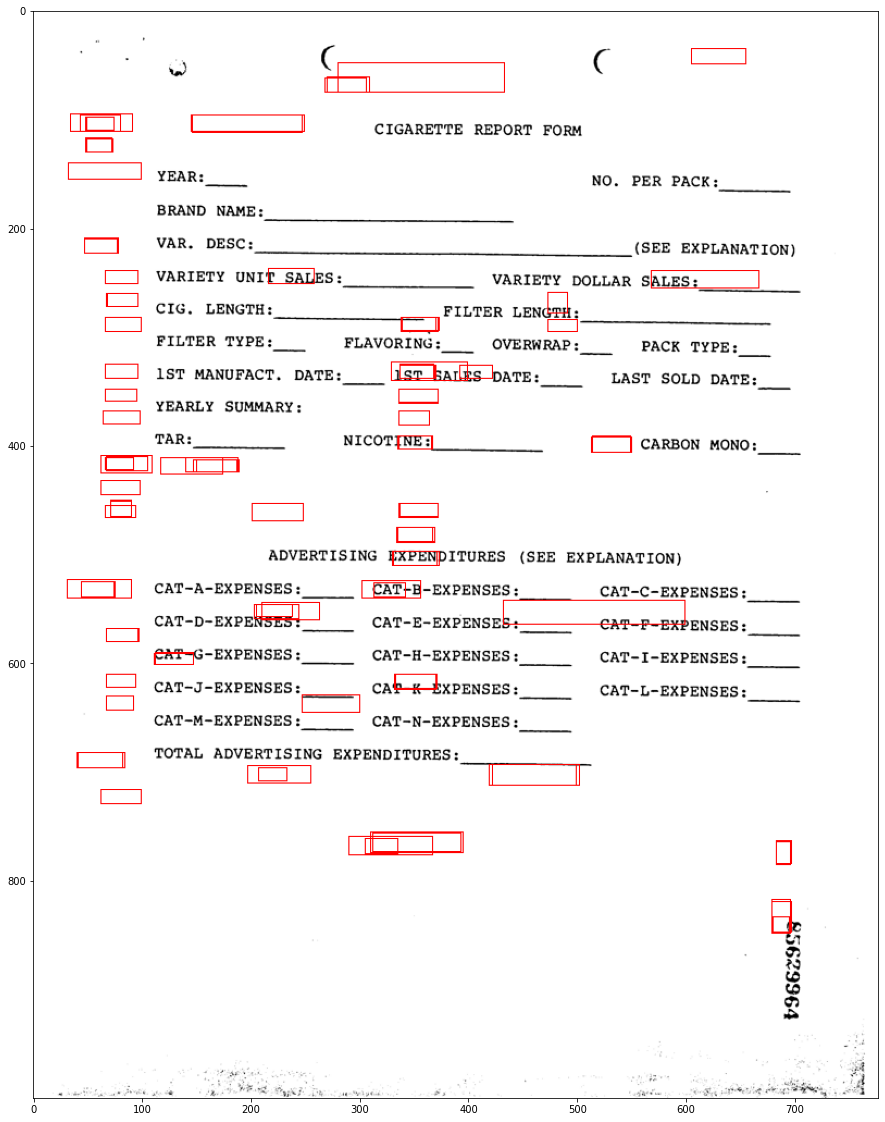

In [4]:
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/85629964.png" , cv2.IMREAD_COLOR)
label_list = ["question", "answer" , "header", "other"]
for box in boxes:
    cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))


plt.figure(figsize=(20 , 20))
plt.imshow(test_img)
plt.show()
    

In [5]:
print(output[0]['labels'])

tensor([1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 4, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 2, 3, 1,
        2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 1, 3, 3, 1, 2,
        1, 2, 1, 1, 3, 3, 2, 2, 2, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 3, 1, 1, 2, 1,
        3, 1, 1, 2], device='cuda:0')
